In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from   statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import statsmodels.tsa as smtsa
from   statsmodels.tsa.stattools import adfuller

%matplotlib inline

In [2]:
DATA = '../../../data'

ibm = pd.read_csv(f'{DATA}/IBM.csv')
ibm = ibm[['Date', 'Adj Close']]
ibm.rename(columns={'Adj Close': 'Close'}, inplace=True)
ibm.head()

,Date,Close
0,2001-01-02,56.790684
1,2001-01-03,63.361145
2,2001-01-04,62.398586
3,2001-01-05,62.942654
4,2001-01-08,62.649712


In [3]:
ibm.shape

(4718, 2)

In [4]:
mean1, mean2 = ibm.iloc[:2359].Close.mean(), ibm.iloc[2359:].Close.mean()
var1, var2 = ibm.iloc[:2359].Close.var(), ibm.iloc[2359:].Close.var()
print(f'Means: {mean1:.2f}, {mean2:.2f}')
print(f'Vars: {var1:.2f}, {var2:.2f}')

Means: 67.81, 137.18
Vars: 168.09, 248.29


In [5]:
adf_result = adfuller(ibm.Close.tolist())
print(f'ADF: {adf_result[0]:.2f}, (p={adf_result[1]:.2f})')

ADF: -1.38, (p=0.59)


More negative ADFs more likely to be stationary
p = 0.59: cannot reject null: (i.e., most likely is non-stationary)

In [6]:
# Force an ARMA(1, 1) on non-stationary signal
arma_obj = smtsa.arima_model.ARMA(ibm.Close.tolist(), order=(1, 1))\
                .fit(maxlag=30, method='mle', trend='nc')

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

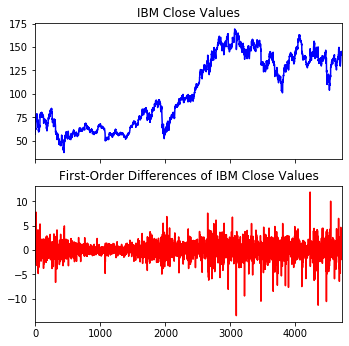

In [7]:
first_order_diff = ibm.Close.diff(1)
fig, ax = plt.subplots(2, sharex=True)
fig.set_size_inches(5.5, 5.5)
ibm.Close.plot(ax=ax[0], color='b')
ax[0].set_title('IBM Close Values')
first_order_diff.plot(ax=ax[1], color='r')
ax[1].set_title('First-Order Differences of IBM Close Values');

In [8]:
def plotds(xt, nlag=30, fig_size=(12, 10)):
    if not isinstance(xt, pd.Series):
         xt = pd.Series(xt)
    plt.figure(figsize=fig_size)
    layout = (2, 2)
    
    # Assign axes
    ax_xt = plt.subplot2grid(layout, (0, 0), colspan=2)
    ax_acf= plt.subplot2grid(layout, (1, 0))
    ax_pacf = plt.subplot2grid(layout, (1, 1))
    
    # Plot graphs
    xt.plot(ax=ax_xt)
    ax_xt.set_title('Time Series')
    plot_acf(xt, lags=50, ax=ax_acf)
    plot_pacf(xt, lags=50, ax=ax_pacf)
    plt.tight_layout()
    return None

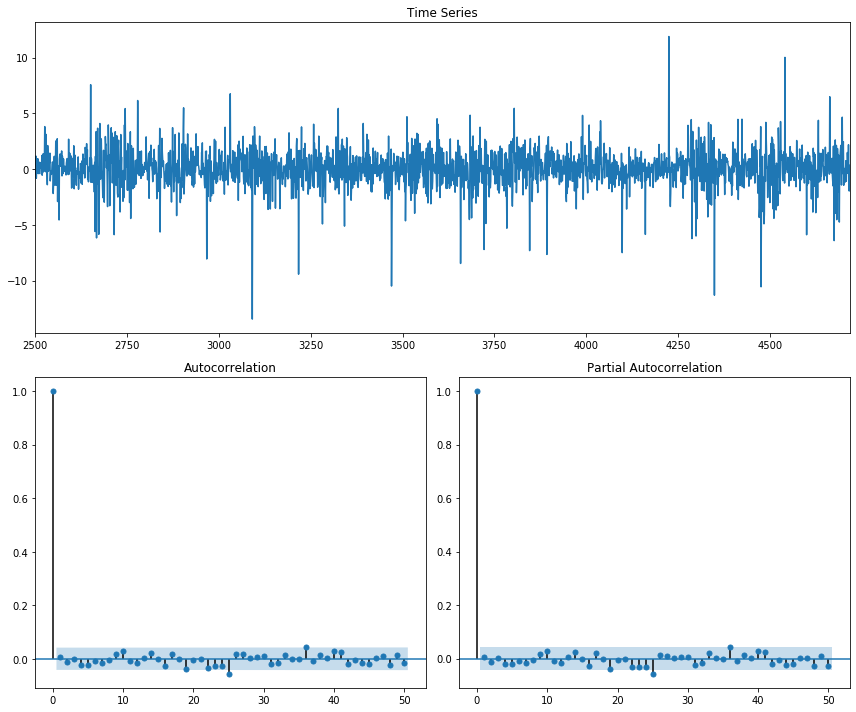

In [9]:
plotds(first_order_diff[2500:])

In [10]:
# optimize ARMA params
params = []
cut = 2500
for d in range(1, 3):
    for ar in range(0, 3):
        for ma in range(0, 3):
            aics = []
            for ts in [ibm.Close[:cut], ibm.Close[cut:]]:
                try:
                    arima_obj = smtsa.arima_model.ARIMA(
                        ts.tolist(), order=(ar, d, ma))
                    arima_fit = arima_obj.fit()
                    aics.append(arima_fit.aic)
                except ValueError:
                    aics.append(np.nan)
            params.append([ar, d, ma] + aics)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [11]:
par_table = pd.DataFrame(params, 
                         columns=['ar', 'd', 'ma', 'aic1', 'aic2'])
par_table.sort_values('aic1', inplace=True)
par_table

,ar,d,ma,aic1,aic2
0,0,1,0,7697.033725,8671.139619
3,1,1,0,7698.826299,8673.043933
1,0,1,1,7698.831001,8673.041420
7,2,1,1,7699.734318,8676.607123
6,2,1,0,7700.499089,8674.679704
2,0,1,2,7700.504305,8674.662869
8,2,1,2,7701.837238,8673.707010
10,0,2,1,7704.117951,8677.578374
13,1,2,1,7705.911962,8679.473367
11,0,2,2,7705.914921,8679.471450


In [12]:
# Eval fit with optimal params
arima_obj1 = smtsa.arima_model.ARIMA(ibm.Close[:cut].tolist(), 
                                     order=(0, 1, 0))
arima_obj2 = smtsa.arima_model.ARIMA(ibm.Close[cut:].tolist(), 
                                     order=(0, 1, 0))
arima_fit1 = arima_obj1.fit(disp=0)
arima_fit2 = arima_obj2.fit(disp=0)
arima_fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 2499
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -3846.517
Method:                           css   S.D. of innovations              1.128
Date:                Mon, 17 Feb 2020   AIC                           7697.034
Time:                        07:04:18   BIC                           7708.681
Sample:                             1   HQIC                          7701.262
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0209      0.023      0.925      0.355      -0.023       0.065
==============================================================================
"""

In [13]:
arima_fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 2217
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -4333.570
Method:                           css   S.D. of innovations              1.709
Date:                Mon, 17 Feb 2020   AIC                           8671.140
Time:                        07:04:18   BIC                           8682.547
Sample:                             1   HQIC                          8675.307
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0147      0.036      0.406      0.685      -0.056       0.086
==============================================================================
"""

In [14]:
# Evaluate predictions
pred1 = np.append([0, 0], arima_fit1.fittedvalues.tolist())
diffval1 = np.append([0, 0], arima_fit1.resid + arima_fit1.fittedvalues)

pred2 = np.append([0, 0], arima_fit2.fittedvalues.tolist())
diffval2 = np.append([0, 0], arima_fit2.resid + arima_fit2.fittedvalues)

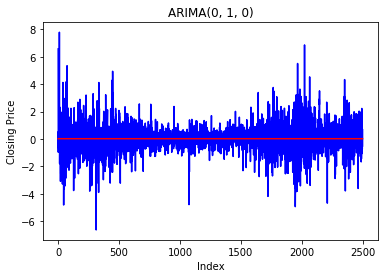

In [15]:
plt.plot(diffval1[2:], color='b')
plt.plot(pred1[2:], color='r')
plt.title('ARIMA(0, 1, 0)')
plt.xlabel('Index')
plt.ylabel('Closing Price');

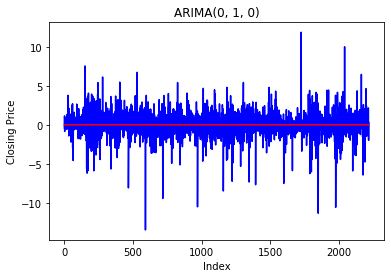

In [16]:
plt.plot(diffval2[2:], color='b')
plt.plot(pred2[2:], color='r')
plt.title('ARIMA(0, 1, 0)')
plt.xlabel('Index')
plt.ylabel('Closing Price');

In [18]:
# Forecast with CI
f, err, ci = arima_fit2.forecast(40)

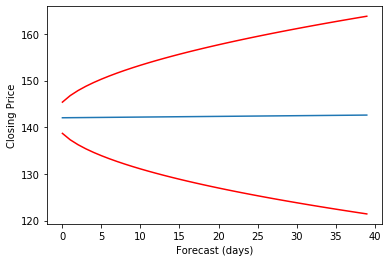

In [22]:
plt.plot(f)
plt.plot(ci, color='r')
plt.xlabel('Forecast (days)')
plt.ylabel('Closing Price');